In [1]:
import numpy as np
# Importing Pandas Library 
import pandas as pd
import matplotlib.pyplot as plt
from preprocessing import *
import os
import joblib
from sklearn.preprocessing import MinMaxScaler
from utils import *

import tensorflow as tf
from tensorflow.keras.models import Model, load_model

from models.EEGNet import *

from sklearn.metrics import confusion_matrix

from preprocessing import *

import warnings
warnings.filterwarnings("ignore")

2024-10-18 17:34:40.714475: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-18 17:34:40.721373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 17:34:40.729068: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 17:34:40.731318: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 17:34:40.737301: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [21]:
model = load_model(r'./checkpoints/orthogonal_trainable_true.keras')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ eyebrows input      │ (None, 4, 128, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ left input          │ (None, 4, 128, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right input         │ (None, 4, 128, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ both input          │ (None, 4, 128, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teeth input         │ (None, 4, 128, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eyebrows            │ (None, 64)        │      2,848 │ eyebrows          │
│ (Functional)        │                   │            │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ left (Functional)   │ (None, 64)        │      2,848 │ left input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right (Functional)  │ (None, 64)        │      2,848 │ right input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ both (Functional)   │ (None, 192)       │     19,296 │ both input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teeth (Functional)  │ (None, 64)        │      2,848 │ teeth input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 448)       │          0 │ eyebrows[0][0],   │
│ (Concatenate)       │                   │            │ left[0][0],       │
│                     │                   │            │ right[0][0],      │
│                     │                   │            │ both[0][0],       │
│                     │                   │            │ teeth[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │    459,776 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 768)       │    393,984 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 128, 6)    │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax             │ (None, 128, 6)    │          0 │ reshape[0][0]     │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,225,122 (16.12 MB)

 Trainable params: 1,407,936 (5.37 MB)

 Non-trainable params: 1,312 (5.12 KB)

 Optimizer params: 2,815,874 (10.74 MB)

In [4]:
label_name = ['eyebrows', 'left', 'right', 'both', 'teeth']

train_x = []
test_x = []
train_y = []
test_y = []
for label in label_name:
    dataset = np.load(f'./running/{label}.npz')

    print(dataset['train_x'].shape, dataset['train_y'].shape, dataset['test_x'].shape, dataset['test_y'].shape)
    train_x.append(dataset['train_x'][:51500])
    train_y.append(dataset['train_y'][:51500])
    test_x.append(dataset['test_x'][:12900])
    test_y.append(dataset['test_y'][:12900])

train_x = np.concatenate(train_x)
train_y = np.concatenate(train_y)
test_x = np.concatenate(test_x)
test_y = np.concatenate(test_y)


train_x = train_x.transpose((0, 2, 1))
test_x = test_x.transpose((0, 2, 1))

train_x = np.expand_dims(train_x, axis=-1)
test_x = np.expand_dims(test_x, axis=-1)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(65972, 128, 20) (65972, 128) (16493, 128, 20) (16493, 128)
(57701, 128, 20) (57701, 128) (14426, 128, 20) (14426, 128)
(53477, 128, 20) (53477, 128) (13370, 128, 20) (13370, 128)
(51868, 128, 20) (51868, 128) (12968, 128, 20) (12968, 128)
(51752, 128, 20) (51752, 128) (12939, 128, 20) (12939, 128)
(257500, 20, 128, 1) (257500, 128) (64500, 20, 128, 1) (64500, 128)


In [22]:
y_train_pred = model.predict([
    train_x[:, :4], 
    train_x[:, 4:8], 
    train_x[:, 8:12],
    train_x[:, 12:16],
    train_x[:, 16:20]
])

y_test_pred = model.predict([
    test_x[:, :4], 
    test_x[:, 4:8], 
    test_x[:, 8:12],
    test_x[:, 12:16],
    test_x[:, 16:20]
])
y_train_pred.shape, y_test_pred.shape

8047/8047 ━━━━━━━━━━━━━━━━━━━━ 7s 854us/step
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 2s 852us/step


((257500, 128, 6), (64500, 128, 6))

In [23]:
y_train_pred_argmax = np.argmax(y_train_pred, 2)
y_test_pred_argmax = np.argmax(y_test_pred, 2)

y_train_pred_argmax.shape, y_test_pred_argmax.shape

((257500, 128), (64500, 128))

In [24]:
iou_results = {}
for _class in range(5):
    iou_metric = tf.keras.metrics.IoU(num_classes=6, target_class_ids=[_class+1])
    print(f"Class [{label_name[_class]}] - Train:", iou_metric(train_y, y_train_pred_argmax))
    print(f"Class [{label_name[_class]}] - Test:", iou_metric(test_y, y_test_pred_argmax))
    iou_results[label_name[_class]] = [
        tf.get_static_value(iou_metric(train_y, y_train_pred_argmax)), 
        tf.get_static_value(iou_metric(test_y, y_test_pred_argmax))
    ]

Class [eyebrows] - Train: tf.Tensor(0.8960951, shape=(), dtype=float32)
Class [eyebrows] - Test: tf.Tensor(0.89533913, shape=(), dtype=float32)
Class [left] - Train: tf.Tensor(0.92925864, shape=(), dtype=float32)
Class [left] - Test: tf.Tensor(0.92895573, shape=(), dtype=float32)
Class [right] - Train: tf.Tensor(0.93442464, shape=(), dtype=float32)
Class [right] - Test: tf.Tensor(0.93421793, shape=(), dtype=float32)
Class [both] - Train: tf.Tensor(0.8744813, shape=(), dtype=float32)
Class [both] - Test: tf.Tensor(0.8741605, shape=(), dtype=float32)
Class [teeth] - Train: tf.Tensor(0.916211, shape=(), dtype=float32)
Class [teeth] - Test: tf.Tensor(0.91574705, shape=(), dtype=float32)


<Axes: >

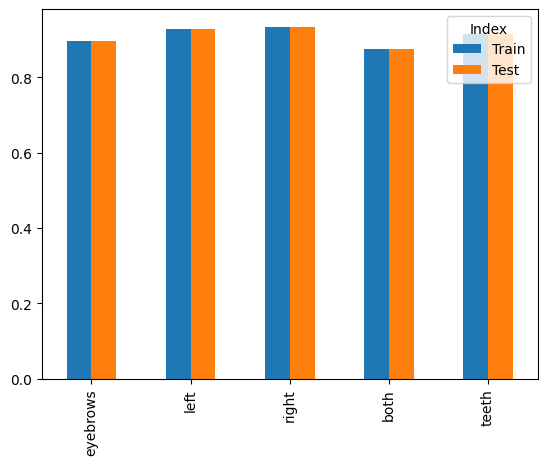

In [25]:
iou_results['Index'] = ['Train', 'Test']
pd.DataFrame.from_dict(iou_results).set_index('Index').T.plot(kind='bar')

In [30]:
cm_total = np.zeros((6, 6))

for y_t, y_p in zip(train_y, y_train_pred_argmax):
    cm = confusion_matrix(y_t, y_p, labels=[0, 1, 2, 3, 4, 5])
    cm = np.array(cm)
    cm_total = cm_total + cm

result = []
for cls in range(6):
    tp = cm_total[cls, cls]
    fn = np.sum(np.delete(cm_total[cls, :], cls))
    fp = np.sum(np.delete(cm_total[:, cls], cls))
    tn = np.delete(cm_total, cls, axis=0)
    tn = np.sum(np.delete(tn, cls, axis=1))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = (2 * precision * recall) / (precision + recall)
    acc = (tp + tn) / (tp + fn + tn + fp)
    specifity = tn/(tn+fp)

    result.append([precision, recall, f1, acc, specifity])

result = np.array(result)

print(f'precision, recall, f1, acc, specifity\n{result}')

precision, recall, f1, acc, specifity
[[0.95498714 0.9556605  0.9553237  0.95451162 0.95332106]
 [0.94697235 0.94343558 0.94520065 0.98763337 0.9932666 ]
 [0.96673525 0.95995346 0.96333242 0.99269566 0.99633177]
 [0.96550741 0.96669515 0.96610092 0.99345801 0.99631426]
 [0.93573769 0.93035435 0.93303825 0.98784129 0.99359982]
 [0.95017962 0.96244641 0.95627368 0.99202491 0.994972  ]]


In [31]:
cm_total = np.zeros((6, 6))

for y_t, y_p in zip(test_y, y_test_pred_argmax):
    cm = confusion_matrix(y_t, y_p, labels=[0, 1, 2, 3, 4, 5])
    cm = np.array(cm)
    cm_total = cm_total + cm

result = []
for cls in range(6):
    tp = cm_total[cls, cls]
    fn = np.sum(np.delete(cm_total[cls, :], cls))
    fp = np.sum(np.delete(cm_total[:, cls], cls))
    tn = np.delete(cm_total, cls, axis=0)
    tn = np.sum(np.delete(tn, cls, axis=1))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = (2 * precision * recall) / (precision + recall)
    acc = (tp + tn) / (tp + fn + tn + fp)
    specifity = tn/(tn+fp)

    result.append([precision, recall, f1, acc, specifity])

result = np.array(result)

print(f'precision, recall, f1, acc, specifity\n{result}')

precision, recall, f1, acc, specifity
[[0.95435402 0.95436196 0.95435799 0.9534679  0.95253829]
 [0.9447544  0.94144803 0.94309832 0.98717442 0.99299378]
 [0.96619662 0.9588745  0.96252164 0.9925132  0.9962617 ]
 [0.96443134 0.96666435 0.96554655 0.99339208 0.99622341]
 [0.9339769  0.93029245 0.93213103 0.98760065 0.99337444]
 [0.94823945 0.96186402 0.95500314 0.9918624  0.99482127]]
